In [1]:
import src.db_read as dbrd
import src.save_grid as svgrd
import src.grid_topol as grdtpl
import src.weather as wth 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import contextily as ctx
from shapely.geometry import box
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

### Load census and grids

In [2]:
df_grid_set = pd.read_hdf("input_data/valid_grids")  # Source: pylovo
df_grid_set.head()

,plz,kcid,bcid,x,y,Einwohner,x_census,y_census
0,90461,1,22,4.400701e+06,2.925878e+06,13424.0,4400500.0,2925500.0
1,80933,1,-2,4.437005e+06,2.790850e+06,2579.0,4437500.0,2790500.0
2,81829,1,21,4.446704e+06,2.780981e+06,1255.0,4446500.0,2780500.0
3,81829,1,22,4.446772e+06,2.781089e+06,4195.0,4446500.0,2781500.0
4,81927,1,22,4.442523e+06,2.783343e+06,5266.0,4442500.0,2783500.0


In [4]:
df_census = pd.read_csv("input_data/Zensus2022_Bevoelkerungszahl_1km-Gitter.csv", sep=";")  # Source: https://atlas.zensus2022.de/
df_census.head()

,GITTER_ID_1km,x_mp_1km,y_mp_1km,Einwohner
0,CRS3035RES1000mN2689000E4337000,4337500,2689500,4
1,CRS3035RES1000mN2689000E4341000,4341500,2689500,11
2,CRS3035RES1000mN2690000E4341000,4341500,2690500,4
3,CRS3035RES1000mN2691000E4340000,4340500,2691500,3
4,CRS3035RES1000mN2691000E4341000,4341500,2691500,22


### Sample a set of representative grids (N~1500)

1. Sample census cell based on number of inhabitants (p(cell)~N_inhabitants)
2. If cell contains 1 or more simulated grids:

    a) Sample one of the contained grids randomly (all with equal probability)

    b) Assign as grid position the transformer position


3. If cell contains no simulated grid:
    
    a) Take all grids with the closest population density to the census cell

    b) Sample one grid out of this subset

    c) Take as grid position the center of the census cell

4. From position: assign zip code and regiostar region

##### 1. Sample 1500 census cells

In [6]:
# Normalize inhabitants to get probabilities
probabilities = df_census['Einwohner'] / df_census['Einwohner'].sum()

# Sample 1000 rows with replacement=False, weighted by inhabitants
df_sampled_cells = df_census.sample(n=1500, weights=probabilities, replace=True, random_state=3)
df_sampled_cells.head()

,GITTER_ID_1km,x_mp_1km,y_mp_1km,Einwohner
111605,CRS3035RES1000mN3125000E4089000,4089500,3125500,6563
135611,CRS3035RES1000mN3194000E4475000,4475500,3194500,5880
61044,CRS3035RES1000mN2947000E4382000,4382500,2947500,212
104546,CRS3035RES1000mN3106000E4470000,4470500,3106500,2553
175412,CRS3035RES1000mN3334000E4247000,4247500,3334500,3490


In [7]:
df_sampled_cells.duplicated().sum()

np.int64(28)

In [8]:
df_sampled_cells["Einwohner"].describe()

count     1500.000000
mean      2971.359333
std       3352.060373
min          4.000000
25%        650.000000
50%       1871.000000
75%       4112.250000
max      22097.000000
Name: Einwohner, dtype: float64

In [9]:
# Mean of sample matches expectation value, so all good
(df_census["Einwohner"]**2).sum()/df_census["Einwohner"].sum()

np.float64(3082.4239705301843)

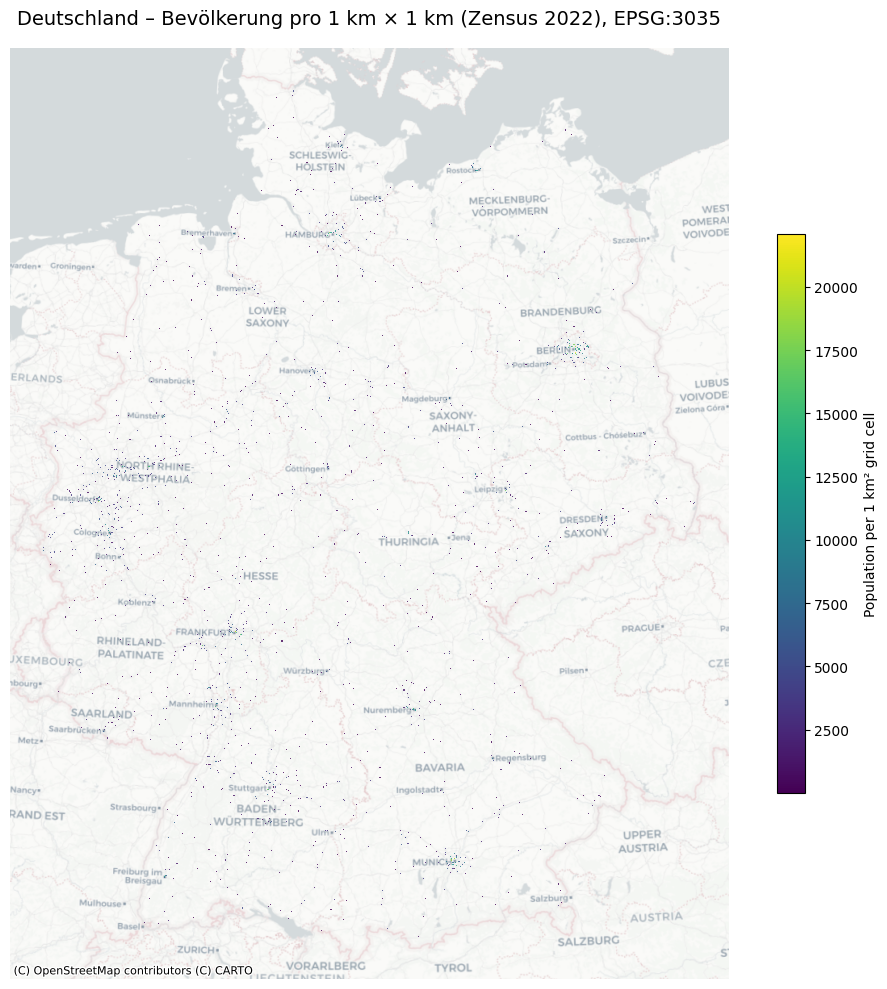

In [10]:
# Step 1: Column definitions
df=df_sampled_cells.copy()
x_col    = "x_mp_1km"    # centroid X [m]
y_col    = "y_mp_1km"    # centroid Y [m]
pop_col  = "Einwohner"    # population

half_size = 500          # half side‐length in metres

# Step 2: Build square polygons in EPSG:3035
polygons = df.apply(
    lambda row: box(
        row[x_col] - half_size,
        row[y_col] - half_size,
        row[x_col] + half_size,
        row[y_col] + half_size
    ),
    axis=1
)

gdf = gpd.GeoDataFrame(
    df[[pop_col]],
    geometry=polygons,
    crs="EPSG:3035"
)

# Step 3: Plot in EPSG:3035 so boxes remain true squares
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the grid cells
gdf.plot(
    ax=ax,
    column=pop_col,
    cmap="viridis",
    linewidth=0,
    edgecolor="none",
    alpha=0.8,
    legend=True,
    legend_kwds={
        "label": "Population per 1 km² grid cell",
        "shrink": 0.6
    }
)

# Optional: add a basemap reprojected on the fly
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=gdf.crs.to_string()
)

# Formatting
ax.set_title(
    "Deutschland – Bevölkerung pro 1 km × 1 km (Zensus 2022), EPSG:3035",
    fontsize=14
)
ax.set_aspect("equal")      # ensure equal axis scales
ax.set_axis_off()

plt.tight_layout()
plt.show()

##### 2. + 3. Assign Representative Grid To Cell

In [11]:
### Step 2 + 3 - Assign grid to cell: ###
def assign_grid(x_cell, y_cell, N_inh, df_grids):
    df_g = df_grids.copy()

    ### 2a) Check if cell contains sampled grids already:
    df_same_cell = df_g[(df_g["x_census"]==x_cell) & (df_g["y_census"]==y_cell)]
    if len(df_same_cell)!=0:
        sample_grid = df_same_cell.sample(n=1, random_state=x_cell)

        #2b) Assign trafo pos as grid pos
        sample_grid.drop(columns=["x_census", "y_census"], inplace=True)
        return sample_grid
    
    
    ### 3a) Take all grids with closest population density:
    df_g['diff'] = (df_g['Einwohner'] - N_inh).abs()
    min_diff = df_g['diff'].min()
    closest_rows = df_g[df_g['diff'] == min_diff].drop(columns='diff')

    # 3b) Sample one grid out of selection
    sample_grid = closest_rows.sample(n=1, random_state=x_cell)

    # 3c) Take cell center as trafo pos
    sample_grid[["x","y"]] = (x_cell, y_cell)
    sample_grid.drop(columns=["x_census", "y_census"], inplace=True)
    return sample_grid

In [12]:
df_sampled_grids = df_sampled_cells.apply(lambda row: assign_grid(row["x_mp_1km"], row["y_mp_1km"], row["Einwohner"], df_grid_set), axis=1)
df_sampled_grids = pd.concat(df_sampled_grids.values, ignore_index=True).rename(columns={"plz":"plz_pylovo", "Einwohner":"pop_density_1km2_cell"})
df_sampled_grids.head()

,plz_pylovo,kcid,bcid,x,y,pop_density_1km2_cell
0,86165,2,22,4089500.0,3125500.0,6580.0
1,86154,1,-6,4475500.0,3194500.0,5947.0
2,95643,2,97,4382500.0,2947500.0,212.0
3,86163,3,6,4470500.0,3106500.0,2552.0
4,82024,1,26,4247500.0,3334500.0,3514.0


In [14]:
df_sampled_grids.duplicated().sum()

np.int64(28)

In [15]:
df_sampled_grids["pop_density_1km2_cell"].describe()

count     1500.000000
mean      2969.886000
std       3342.702565
min          4.000000
25%        651.500000
50%       1871.000000
75%       4108.000000
max      21175.000000
Name: pop_density_1km2_cell, dtype: float64

#### 4. Assign zip-code and regiostar7

Lattitude and Longitude

In [16]:
transformer = Transformer.from_crs("EPSG:3035", "EPSG:4326", always_xy=True)
df_sampled_grids[["lon","lat"]] = df_sampled_grids.apply(lambda row: transformer.transform(row["x"], row["y"]), axis=1).apply(pd.Series)
df_sampled_grids.head()

,plz_pylovo,kcid,bcid,x,y,pop_density_1km2_cell,lon,lat
0,86165,2,22,4089500.0,3125500.0,6580.0,6.687110,51.193351
1,86154,1,-6,4475500.0,3194500.0,5947.0,12.242026,51.839349
2,95643,2,97,4382500.0,2947500.0,212.0,10.851278,49.637022
3,86163,3,6,4470500.0,3106500.0,2552.0,12.132312,51.050139
4,82024,1,26,4247500.0,3334500.0,3514.0,8.902364,53.113858


zip code

In [17]:
shapefile_path = "input_data/plz-5stellig.shp"  # Source: https://www.suche-postleitzahl.org/downloads
gdf_zip = gpd.read_file(shapefile_path)

In [18]:
def lookup_zip_code(lon, lat, gdf_zip):
    point = Point(lon, lat)  # Note: shapely expects (x, y) = (lon, lat)

    # Ensure the CRS is set and transform if necessary
    if gdf_zip.crs is None:
        gdf_zip.set_crs(epsg=4326, inplace=True)
    elif gdf_zip.crs.to_epsg() != 4326:
        gdf_zip = gdf_zip.to_crs(epsg=4326)

    # Spatial join to find the matching PLZ polygon
    matching_row = gdf_zip[gdf_zip.contains(point)]

    # Extract PLZ
    if not matching_row.empty: return matching_row.iloc[0]["plz"]
    else: return np.nan

In [19]:
df_sampled_grids["plz"] = df_sampled_grids.apply(lambda row: lookup_zip_code(row["lon"], row["lat"], gdf_zip), axis=1)
df_sampled_grids = df_sampled_grids.dropna(subset=['plz']) # Drop those for which Gemeindeschlüssel could not be found (shouldn't be more than 1%)
df_sampled_grids.head()

,plz_pylovo,kcid,bcid,x,y,pop_density_1km2_cell,lon,lat,plz
0,86165,2,22,4089500.0,3125500.0,6580.0,6.687110,51.193351,41464
1,86154,1,-6,4475500.0,3194500.0,5947.0,12.242026,51.839349,06844
2,95643,2,97,4382500.0,2947500.0,212.0,10.851278,49.637022,91085
3,86163,3,6,4470500.0,3106500.0,2552.0,12.132312,51.050139,06712
4,82024,1,26,4247500.0,3334500.0,3514.0,8.902364,53.113858,28357


Gemeindeschlüssel

In [20]:
# Path to your downloaded VG250 shapefile:
MUNICI_SHP = 'input_data/VG250_GEM.shp'     # Source: https://gdz.bkg.bund.de/index.php/default/verwaltungsgebiete-1-250-000-stand-01-01-vg250-01-01.html

# Read municipalities
gdf_munic = gpd.read_file(MUNICI_SHP)

# Make sure it’s in WGS84 (lat/lon)
if gdf_munic.crs.to_epsg() != 4326:
    gdf_munic = gdf_munic.to_crs(epsg=4326)

# Build spatial index
sindex = gdf_munic.sindex

In [21]:
def lookup_gemeindeschluessel(lat, lon):
    """
    Given WGS84 latitude and longitude,
    returns the matching Gemeinde-Schlüssel (AGS) and name.
    """
    pt = Point(lon, lat)

    # first find candidate polygons
    idx_candidates = list(sindex.intersection(pt.bounds))
    candidates = gdf_munic.iloc[idx_candidates]

    # then test which one contains the point
    match = candidates[candidates.contains(pt)]
    if match.empty:
        return None

    row = match.iloc[0]
    return row['AGS'], row['GEN']   # Gemeindeschlüssel + municipality name

In [22]:
df_sampled_grids[["gemeindeschlüssel", "name"]] = df_sampled_grids.apply(lambda row: lookup_gemeindeschluessel(row["lat"], row["lon"]), axis=1).apply(pd.Series)
df_sampled_grids = df_sampled_grids.dropna(subset=['gemeindeschlüssel']) # Drop those for which Gemeindeschlüssel could not be found (shouldn't be more than 1%)
df_sampled_grids.head()

,plz_pylovo,kcid,bcid,x,y,pop_density_1km2_cell,lon,lat,plz,gemeindeschlüssel,name
0,86165,2,22,4089500.0,3125500.0,6580.0,6.687110,51.193351,41464,05162024,Neuss
1,86154,1,-6,4475500.0,3194500.0,5947.0,12.242026,51.839349,06844,15001000,Dessau-Roßlau
2,95643,2,97,4382500.0,2947500.0,212.0,10.851278,49.637022,91085,09572164,Weisendorf
3,86163,3,6,4470500.0,3106500.0,2552.0,12.132312,51.050139,06712,15084590,Zeitz
4,82024,1,26,4247500.0,3334500.0,3514.0,8.902364,53.113858,28357,04011000,Bremen


RegioStar7

In [23]:
df_regiostar = pd.read_excel("input_data/regiostar-referenzdateien.xlsx", sheet_name="ReferenzGebietsstand2020")
df_regiostar.head()

,gem_20,gemrs_20,name_20,bev_20,fl_20,vbgem_20,vbgemrs_20,vbgnam_20,land_20,RegioStaR2,RegioStaR4,RegioStaR17,RegioStaR7,RegioStaR5,RegioStaRGem7,RegioStaRGem5,RegioStaR_Stadtregion,RegioStaR_NameStadtregion
0,1001000,10010000000,"Flensburg, Stadt",89934,56.73,1001000,10010000,"Flensburg, Stadt",1,2,22,221,75,54,74,53,NaN,NaN
1,1002000,10020000000,"Kiel, Landeshauptstadt",246601,118.65,1002000,10020000,"Kiel, Landeshauptstadt",1,1,12,121,72,52,72,52,1002000.0,Kiel
2,1003000,10030000000,"Lübeck, Hansestadt",215846,214.19,1003000,10030000,"Lübeck, Hansestadt",1,1,12,121,72,52,72,52,1003000.0,Lübeck
3,1004000,10040000000,"Neumünster, Stadt",79905,71.66,1004000,10040000,"Neumünster, Stadt",1,2,21,211,75,54,74,53,NaN,NaN
4,1051001,10515175001,Albersdorf,3714,17.12,1051975,10515175,Mitteldithmarschen,1,2,22,225,77,55,77,55,NaN,NaN


In [24]:
def get_regiostar_region(AGS, df_regiostar):
    """Get RegioStaR7 typology from Gemeindeschlüssel (AGS)"""
    row = df_regiostar[df_regiostar["gem_20"]==AGS]
    try: return int(row["RegioStaR7"].values[0])
    except: return np.nan

In [25]:
df_sampled_grids["regio7"] = df_sampled_grids.apply(lambda row: get_regiostar_region(int(row["gemeindeschlüssel"]), df_regiostar), axis=1)
df_sampled_grids = df_sampled_grids.dropna(subset=['regio7'])  # Drop those for which regiostar7 could not be found, shouldn't be more than 1%

In [26]:
# Drop general duplicate entries (this will slightly skew the distribution, but prevents simulating the same grid several times):
df_sampled_grids = df_sampled_grids.drop_duplicates().reset_index(drop=True)
df_sampled_grids

,plz_pylovo,kcid,bcid,x,y,pop_density_1km2_cell,lon,lat,plz,gemeindeschlüssel,name,regio7
0,86165,2,22,4089500.0,3125500.0,6580.0,6.687110,51.193351,41464,05162024,Neuss,72.0
1,86154,1,-6,4475500.0,3194500.0,5947.0,12.242026,51.839349,06844,15001000,Dessau-Roßlau,75.0
2,95643,2,97,4382500.0,2947500.0,212.0,10.851278,49.637022,91085,09572164,Weisendorf,74.0
3,86163,3,6,4470500.0,3106500.0,2552.0,12.132312,51.050139,06712,15084590,Zeitz,76.0
4,82024,1,26,4247500.0,3334500.0,3514.0,8.902364,53.113858,28357,04011000,Bremen,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1458,94315,9,29,4480500.0,3118500.0,3272.0,12.280172,51.155237,04539,14729170,Groitzsch,74.0
1459,86169,1,27,4097500.0,3110500.0,5424.0,6.810776,51.061869,41540,05162004,Dormagen,73.0
1460,92224,6,0,4259500.0,3484500.0,351.0,9.051827,54.463139,25813,01054132,Südermarsch,77.0
1461,80995,4,20,4286500.0,2864500.0,732.0,9.529658,48.892757,73635,08119061,Rudersberg,76.0


### Read out pylovo grid data

In [28]:
### Create database object to read grid data from pylovo database
DB = dbrd.DataBase()
DB.show_contents()

Available tables:
['spatial_ref_sys', 'geography_columns', 'geometry_columns', 'res', 'oth', 'betriebsmittel', 'building_clusters', 'lines_result', 'buildings_result', 'sample_set', 'clustering_parameters', 'classification_version', 'buildings_tem', 'consumer_categories', 'postcode_result', 'transformer_classified', 'ags_log', 'ways', 'loadarea', 'postcode', 'transformer_positions', 'transformers', 'ways_result', 'ways_tem', 'grids', 'version', 'grid_parameters', 'ways_tem_vertices_pgr', 'public_2po_4pgr', 'municipal_register']


In [30]:
def retrieve_pylovo_grid(df_region_specs):
    ''' :: df_region_specs must at least include columns:
        - plz_pylovo
        - kcid, bcid
        - plz
        - regio7
        - lat, lon
    '''

    grid_specs = {    # unique grid identifier (as duplicates were dropped)
        "cell_id": f"N{int(df_region_specs['y'])}E{int(df_region_specs['x'])}",
        "plz":  df_region_specs["plz_pylovo"],
        "kcid": df_region_specs["kcid"],
        "bcid": df_region_specs["bcid"]
    }

    ######### Process Pylovo Grid #########
    # Read out pandapower grid associated with plz, kcid, bcid
    net = DB.read_single_ppgrid(grid_specs)
    net = grdtpl.assign_min_linelen(net)        # Adjust and save grid topology
    net = grdtpl.remove_duplicate_loads(net)

    # Retrieve buildings associated with plz, kcid, bcid
    df_buildings = DB.read_buildings(grid_specs, net.bus)

    ######## Process Weather ###########
    location = {"lat": df_region_specs["lat"], 
                "lon": df_region_specs["lon"]
            }

    # Get TMY data from SARAH3 dataset as DataFrame
    df_weather_raw, altitude, selected_months = wth.get_pvgis_tmy_sarah3_dataframe(location["lat"], location["lon"])
    # Add dew point temperature necessary for vehicle simulation
    df_weather_raw["dew_point"] = wth.get_dew_point(df_weather_raw["temp_air"], df_weather_raw["relative_humidity"])
    # Add soil temperature (1.00-2.55m) necessary for ground source heat pumps
    df_weather_raw["soil_temp"] = wth.get_open_meteo_soil_temperature(location["lat"], location["lon"], selected_months)

    df_region_specs["altitude"] = altitude

    ######### Save to file #########
    SF=svgrd.SaveFile(grid_specs)
    SF.save_topology(net, "/raw_data/")
    SF.save_df(df_region_specs, "/raw_data/region")
    SF.save_df(df_buildings, "/raw_data/buildings")
    SF.save_df(df_weather_raw, "/raw_data/weather")

In [ ]:
_ = df_sampled_grids[0:100].apply(retrieve_pylovo_grid, axis=1)

Requesting TMY data from PVGIS (SARAH3) for coordinates (50.357518305974466, 10.681499620201341)...
File results\N3027500E4369500_92224_8_24.h5 created!
Requesting TMY data from PVGIS (SARAH3) for coordinates (53.78330391227916, 10.356461522139634)...
File results\N3408500E4344500_93158_2_5.h5 created!
Requesting TMY data from PVGIS (SARAH3) for coordinates (51.457229304589085, 11.992931971553162)...
File results\N3151500E4459500_90522_1_9.h5 created!
Requesting TMY data from PVGIS (SARAH3) for coordinates (51.1160259320792, 12.835588216487464)...
File results\N3115500E4519500_94496_1_21.h5 created!
Requesting TMY data from PVGIS (SARAH3) for coordinates (54.14921052794566, 11.721551067691587)...
File results\N3450500E4433500_90556_1_-1.h5 created!
Requesting TMY data from PVGIS (SARAH3) for coordinates (48.05498966151296, 9.322905880402391)...
File results\N2771500E4270500_86687_1_38.h5 created!
Requesting TMY data from PVGIS (SARAH3) for coordinates (50.08296174191168, 8.749576101618

In [ ]:
df_sampled_grids.iloc[415:419]

## Anomaly from 416 onwards

,plz_pylovo,kcid,bcid,x,y,pop_density_1km2_cell,lon,lat,plz,gemeindeschlüssel,name,regio7
415,86836,1,13,4.498500e+06,3.082500e+06,1766.0,12.519689,50.826522,08371,14524080,Glauchau,73.0
416,80933,1,18,4.437221e+06,2.789699e+06,9192.0,11.563127,48.209759,80933,09162000,München,71.0
417,83368,1,-2,4.162500e+06,2.948500e+06,335.0,7.806150,49.627941,67806,07333502,Rockenhausen,77.0
418,83059,4,7,4.296500e+06,2.843500e+06,4304.0,9.667253,48.704349,73033,08117026,Göppingen,75.0
